# How to use SyntheticControlMethods: an example using the German Reunification study from [Abadie, Diamond and Hainmueller (2015)](https://web.stanford.edu/~jhain/Paper/AJPS2015a.pdf)


This notebook is meant provide a worked example of how the package can be used, and how to interpret the different plots. As such, this doubles as both an example and documentation (until I publish standalone docs).

In this example, we use data from [Abadie, Diamond and Hainmueller (2015)](https://web.stanford.edu/~jhain/Paper/AJPS2015a.pdf), which estimates the economic impact of the 1990 German reunification on West Germany using the synthetic control method. However, do note that this is not meant to be a replication.

The notebook is divided into four sections:
1. General data requirements for using Synthetic Controls of any kind
1. Using Ordinary Synthetic Controls, Synth()
3. Using Penalized Synthetic Controls, Synth(pen="auto")
4. Using Differenced Synthetic Controls, DiffSynth(pen=0) and DiffSynth(pen="auto")

*Last updated: March 11, 2021.*

In [1]:
#Import packages
import pandas as pd
import numpy as np

from SyntheticControlMethods import Synth, DiffSynth

## Data Requirements

In [2]:
#Import German Reunification data from paper
#Can be found in /datasets folder in repo
data = pd.read_csv("datasets/german_reunification.csv")
data = data.drop(columns="code", axis=1)
data.head()

,country,year,gdp,infrate,trade,schooling,invest60,invest70,invest80,industry
0,USA,1960,2879,NaN,9.693181,43.799999,NaN,NaN,NaN,NaN
1,USA,1961,2929,1.075182,9.444655,NaN,NaN,NaN,NaN,NaN
2,USA,1962,3103,1.116071,9.429324,NaN,NaN,NaN,NaN,NaN
3,USA,1963,3227,1.214128,9.470706,NaN,NaN,NaN,NaN,NaN
4,USA,1964,3420,1.308615,9.725879,NaN,NaN,NaN,NaN,NaN


This is the dataset used in Abadie, Diamond and Hainmueller (2015). However, the purpose of this notebook is not to provide an exact replication, rather to showcase how to use the package. Consequently, I will not be covering what the variables mean, how they were collected etc. for that, see the original paper (link in title). 

### Formatting requirements:
1. **Numerical variables.** Only the unit identifier, in this case "country" can be categorical.
2. **The dataset must be sorted by unit and then by time.** That is, all the observations for any unit should appear consecutively in the dataset. In the above example, USA
3. **Only one unit identifier, preferably in the form of a string with the unit name.** In the above example, both code and country columns are unit identifiers. To use the package, one must be excluded. This can be done by dropping the column from the dataframe or using the exclude_columns argument when calling Synth() or DiffSynth(). The tables and plots will use the unit identifiers as labels, so it preferable to use descriptive identifiers. FOr example, in this case it is better to use "country" instead of "code", as "USA" is more interpretable than "1".
4. **The dataset must contain one treated unit and multiple control units.** The package attempts to find a weighted average of the control units that most closely resembles the treated unit, in terms of covariates and outcome, in the pre-treatment period. Of course, finding a good weighted average only works if there are multiple control units.
5. **No missing values for the outcome, but okay for covariates**. Synthetic Controls use the entire outcome timeseries, and thus do not accept missing values. As such, you have to deal with missing outcome data yourself before using Synth, e.g. by imputation or dropping units. Because the synthetic control methods works only with the pre-treatment average of the covariates for each unit, it is okay to have missing values for covariates. Indeed, most methods for imputing missing values preserve the mean, and so would not affect the pre-treatment average. As such, missing values are not touched in Synth(). If you would like some kind of missing value imputation, you should do it on the dataframe before you feed it to Synth(). For DiffSynth, things are different. Because the first difference is only defined for consecutive values, it is very sensitive to missing values (more on this under DiffSynth() section below). DiffSynth() automatically uses linear interpolation to impute missing values. If you dislike this, you can impute values yourself before feeding the dataframe to DiffSynth().

Note: Variable definitions can be found at the bottom of this notebook, or in Appendix A. of Abadie et al. (2015).

# Using Synth, ordinary Synthetic Controls

Synthetic Control is fit using the **Synth()** class which takes the following inputs:

### Arguments

* **data**: Type: Pandas dataframe. A pandas dataframe containing the dataset. Each row should contain one observation for a unit at a time, including the outcome and covariates. Dataset should be ordered by unit then time.


* **outcome_var**: Type: str. Name of outcome column in data, e.g. "gdp"


* **id_var**: Type: str. Name of unit indicator column in data, e.g. "country"


* **time_var**: Type: str. Name of time column in data, e.g. "year"


* **treatment_period**: Type: int. Time of first observation after the treatment took place, i.e. first observation affected by the treatment effect. E.g. 1990 for german reunification.


* **treated_unit**: Type: str. Name of the unit that recieved treatment, data["id_var"] == treated_unit.


* **n_optim**: Type: int. Default: 10. Number of different initialization values for which the optimization is run. Higher number means longer runtime, but a higher change of a globally optimal solution.


* **pen**: Type: float. Default: 0. Penalization coefficient which determines the relative importance of minimizing the sum of the pairwise difference of each individual control unit in the synthetic control and the treated unit, vis-a-vis the difference between the synthetic control and the treated unit. Higher number means pairwise difference matters more. When pen=0, as is the default, the pairwise differences are completely ignored. This means that unless otherwise specificed, Synth() is generating a classic synthetic control, like the ones in Abadie et al. (2015). __If pen="auto"__, the penalization term will be optimized over, along with V and W, using the pre-treatment data. 


* **exclude_columns**: Type: list. Default: []. List of column names to be excluded from the Synthetic Control. This is practically equivalent to dropping the columns included in the dataframe before running Synth or DiffSynth. That means in the below examples, I could have used exclude_columns=["code"] instead of dropping the column when I loaded the dataset.


* **random_seed**: type: int. Default: 0. Random seed is used to create a numpy.random.default_rng(random_seed) object which is subsequently used in all random processes in the code. Random samples are used to initialize covariate importance matrix, V, and "pen" (if pen="auto") for optimization.

### Methods:

Synth objects have 3 methods:
* **Synth.plot(...)** contains all the plotting functionalities
* **Synth.in_time_placebo(...)** runs in-time placebo tests
* **Synth.in_space_placebo(...)** runs in-space placebo tests

### Attributes:
Synth objects have a 1 attribute:
* **original_data**: Original data is an object that stores variables and results Synth(). Important are weight_df and comparison_df, which are tables with summary information (see below). It also contains e.g. variables derived in the data-processing step. You can see all of them by calling Synth.original_data.__ dict__

We will be using each of these in the following examples.

## Fitting a Synthetic Control and interpreting the results

In [31]:
#Fit synthetic control
sc = Synth(data, "gdp", "country", "year", 1990, "West Germany", n_optim=100)

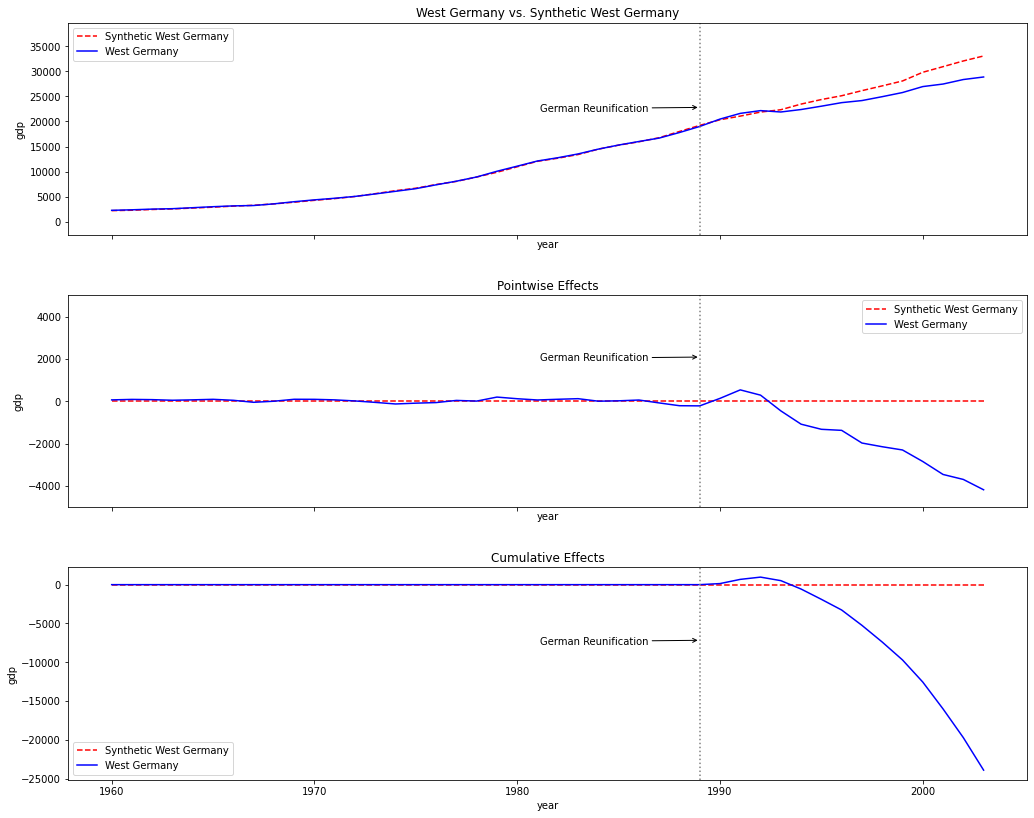

In [32]:
#Visualize
sc.plot(["original", "pointwise", "cumulative"], treated_label="West Germany", 
            synth_label="Synthetic West Germany", treatment_label="German Reunification")

The plot contains three panels. The first panel, "original", shows the data and a counterfactual prediction for the post-treatment period. The second panel, "pointwise", shows the difference between observed data and counterfactual predictions. This is the pointwise causal effect, as estimated by the model. The third panel, "cumulative", adds up the pointwise contributions from the second panel, resulting in a plot of the cumulative effect of the intervention.



In [33]:
#Get weight matrix of solution
sc.original_data.weight_df

,Weight
USA,0.396718
Belgium,0.603282


In [12]:
sc.original_data.rmspe_df

,unit,pre_rmspe,post_rmspe,post/pre
0,West Germany,96.243293,2246.032119,23.337025


The weight_df shows the weight assigned to each in the Synthetic Control. In the example above, USA constitutes ~39% of the Synthetic Control. The weights are constrained to be non-negative and to sum to 1.

All the units that are assigned 0 weight are excluded from the table, but the complete weight matrix can be retrieved using Synth.original_data.w

In [34]:
#RMSPE for Synthetic West Germany vs. West Germany
#Treated unit is always first unit in rmspe_df
sc.original_data.rmspe_df

,unit,pre_rmspe,post_rmspe,post/pre
0,West Germany,96.243293,2246.032119,23.337025


This dataframe shows the root mean square prediction error of the outcome of the synthetic control as compared to the original treated unit, in this case West Germany. A low pre_rmspe means that the synthetic control fits the treated unit well in the pre-treatment period, this is important if we are to trust that it provides a good estimate of what the treated units outcome would have been if the treated unit had not recieved the treatment.

### Evaluating covariate balance

In [7]:
sc.original_data.comparison_df

,West Germany,Synthetic West Germany,WMAPE,Importance
gdp,8169.83,8148.46,1002.35,0.13
infrate,3.39,5.08,1.69,0.12
trade,45.76,71.27,50.07,0.13
schooling,55.78,37.48,18.31,0.13
invest60,0.34,0.26,0.08,0.12
invest70,0.33,0.27,0.06,0.12
invest80,27.02,22.07,4.94,0.12
industry,39.69,35.30,4.39,0.12


### What the columns show:
**self.original_data.treated_unit**: 
  Unscaled, average covariate values of the treated unit
  If method == DSC, then the differenced data is displayed instead

**Synthetic Control**: 
  Unscaled, covariate values of the synthetic control unit
  If method == DSC, then the differenced data is displayed instead

**WMAPE**:
  Weighted Mean Absolute Pairwise Error. For each covariate, how different is each control 
  unit inside the synthetic control from the treated unit, weighted by the weight assigned to each unit.
  This does not change even if method == DSC, as bias scales with value of difference and not change

**Importance**:
  Leading diagonal of V matrix. How important, relative to other covariates,
  is matching on each covariate in the optimization process?
  Note that this is computed after rescaling each covariate to be unit variance, 
  whereas the other columns show the unscaled covariate values.

**Control Group Average**:
  Simple average of all the units in the control group. Not strictly necessary for anything,
  but it is often interesting to see how well the synthetic control is doing. 
  
### How to interpret the table:
A good synthetic control will reconstruct (a) the outcome of the treated unit and (b) the covariates of the treated unit over the pre-treatment period. The plots and the RMSPE help us evaluate (a), this table is meant to evaluate (b).
If the synthetic control has good fit, the following things should be true:

1. Each row of the first two columns should be approximately equal. 
   This means the synthetic control has reconstructed the treated unit values. In this case, whilst the balance is not perfect, the values are quite similar on all covariates. On it's own, in my opinion, this is not enough to convince us that we have found a strong synthetitic control. However, when considered in combination with the validity tests in the subsequent section, we can be confident we have found a strong synthetic control for West Germany. This is generally true, none of these checks are suffici'ent to show the reliability of a synthetic control, but must be evaluated together–if all point to the conclusion that the synthetic control is good, we can be confident.

2. The third column should be small, relative to the values in columns 1 and 2. 
   The closer to zero, the more similar the individual control units inside the syntetic control are to the treated unit.
   The smaller the WMAPE, the lower the potential bias, all else equal. In this case, all of the variables are small, even an order of magnitude smaller, than those in the two first columns–indicating lower risk for bias.

3. There is no fixed way to interpret the importance column. Instead, it should be evaluated using domain knowledge.
   Is the relative importance assigned to each covariate reasonable given the context?

## Validity testing of SC
"To evaluate the credibility of our results, we conduct placebo studies where the treatment of interest is reassigned in the data to a year other than 1990 or to countries different from West Germany." (Abadie et. al, 2015)

### In-time placebo
"We first compare the reunification effect estimated above for West Germany to a placebo effect obtained after reassigning the German reunification in our data to a period before the reunification actually took place. A large placebo estimate would undermine our confidence that the results in Figure 2 are indeed indicative of the economic cost of reunification and not merely driven by lack of predictive power." (Abadie et. al, 2015)

Specifically, we call in_time_placebo(1982), which reruns the model with 1982 as the first observation after the treatment, about 8 years before the actual reunification in 1990.

/Users/oscarengelbrektson/Documents/Minerva/Capstone_Project/SyntheticControlMethods/SyntheticControlMethods/plot.py:256: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


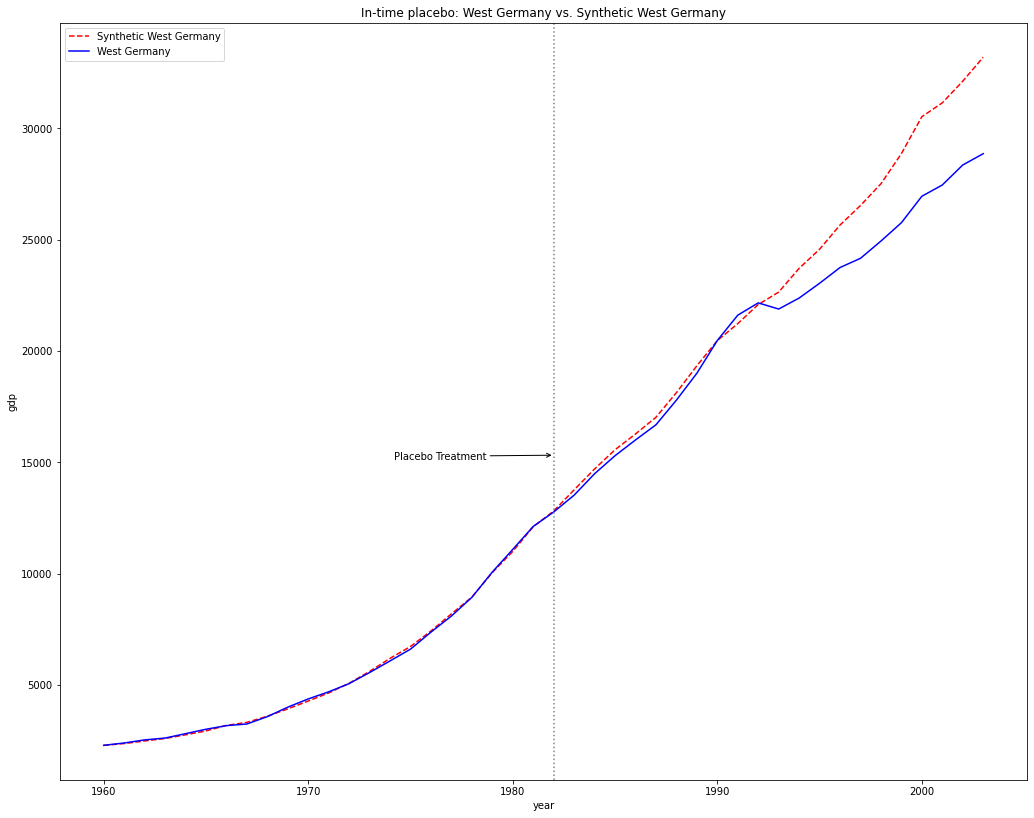

In [8]:
#In-time placebo
#Placebo treatment period is 1982, 8 years earlier
sc.in_time_placebo(1982, n_optim=10)

#Visualize
sc.plot(['in-time placebo'], 
            treated_label="West Germany",
            synth_label="Synthetic West Germany")

Observing the 'in-time placebo' plot, we see that the outcome of the synthetic control and West Germany do not diverge until the true treatment in 1990, remaining close thereuntil. This increases our confidence in the counterfactual outcome provided by the synthetic control.



### In-space placebo
An alternative way to conduct placebo studies is to reassign the treatment in the data to a comparison unit.
In this way, we can obtain synthetic control estimates for countries that did not experience the event of interest. Applying this idea to each country in the donor pool allows us to compare the estimated effect of the German reunification on West Germany to the distribution of placebo effects obtained for other countries. We will
deem the effect of the German reunification on West Germany significant if the estimated effect for West Germany
is unusually large relative to the distribution of placebo effects.

To perform this in-space placebo study, we use the method in_space_placebo(). The results are best visualized using the 'rmspe ratio' plot, which shows the distribution of Post-treatment period RMSPE / Pre-treatment period RMSPE for the true treated unit and each of the placebo treated units. The logic is that in the presence of a large treatment effect, the post-treatment difference between the a unit and its synthetic counterpart would be large relative to the pre-treatment difference.

In [9]:
#Compute in-space placebos
sc.in_space_placebo(15)

/Users/oscarengelbrektson/Documents/Minerva/Capstone_Project/SyntheticControlMethods/SyntheticControlMethods/plot.py:234: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


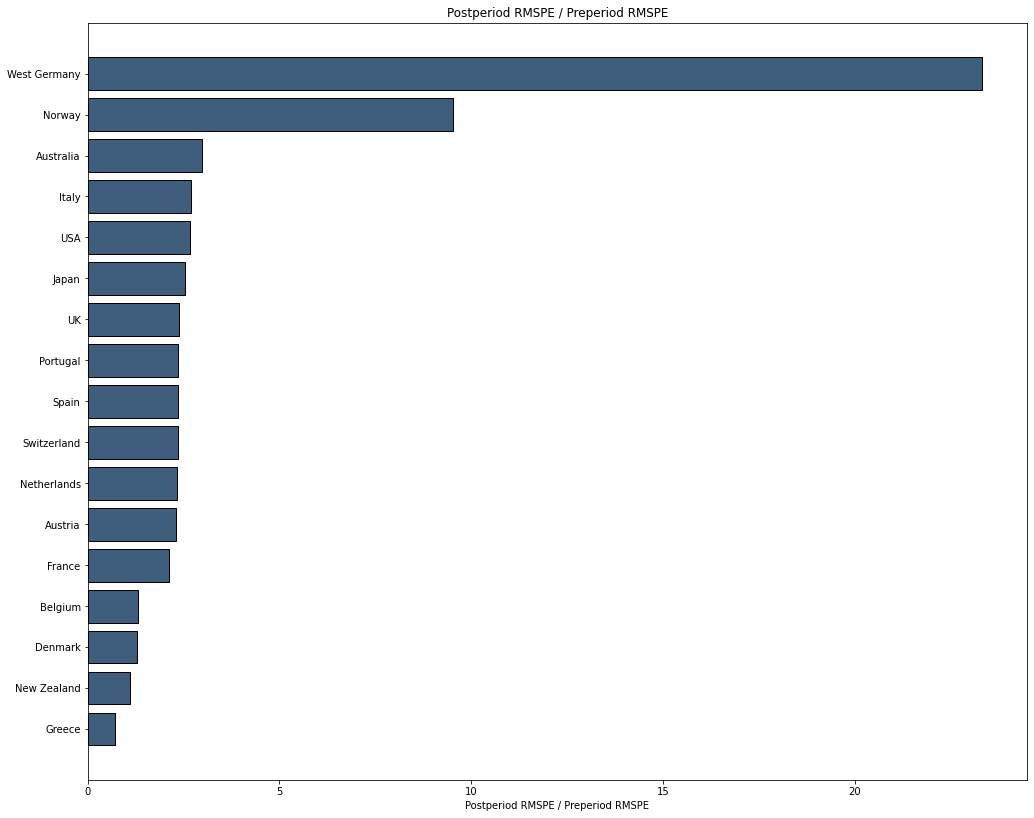

In [10]:
#Visualize
sc.plot(['rmspe ratio'])

West Germany is a clear outlier in the Post-period / pre-period RMSPE distribution, more than twice as extreme as any of the placebo treated units. This increases our confidence in the synthetic control estimates.

# Replication using Penalized Synthetic Control

You can think of the ordinary synthetic control method as trying to find weights such that the synthetic control unit is maximally similar to the treated unit AFTER you mix the control units. Penalized Synthetic Controls try to find weights such that the control units are maximally similar AFTER you mix them into a synthetic unit, but also before you mix them. I.e. you would prefer for the units inside the synthetic control to be similar to the treated unit even before you mix them. If the relationship between the outcome and the covariates is non-linear, then the synthetic control is biased and the bias grows with the difference before mixing (more on this in README.md).

If you set pen="auto", the synthetic control find a penalization coefficient that strikes a balance between fit before and after mixing, such that the resulting synthetic control is best able to predict the outcome of the treated unit. Beyond that, you interact with the Synth(pen="auto") exactly the same way as you do Synth(pen=0), only the results might look different. In the case of West Germany, they look exactly the same.

In [11]:
#Fit synthetic control
sc_pen = Synth(data, "gdp", "country", "year", 1990, "West Germany",
               n_optim=30, pen="auto", exclude_columns=["code"])

#### Note: All the code after this point will be exactly the same, only the synthetic control itself will be different

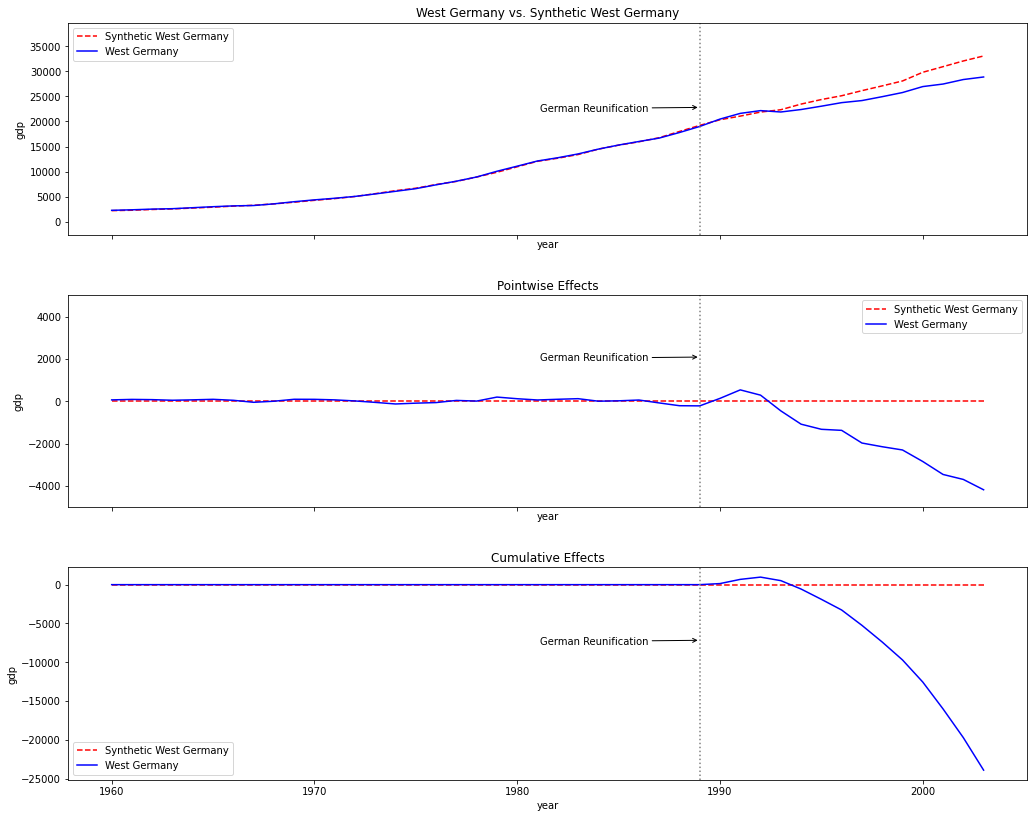

In [12]:
#Visualize
sc_pen.plot(["original", "pointwise", "cumulative"], treated_label="West Germany", 
            synth_label="Synthetic West Germany", treatment_label="German Reunification")

In [13]:
sc_pen.original_data.weight_df

,Weight
USA,0.396718
Belgium,0.603282


In [14]:
#Look at the penalization coefficient
sc_pen.original_data.pen

0.011276293581664473

In [15]:
#RMSPE for Synthetic West Germany vs. West Germany
#Treated unit is always first unit in rmspe_df
sc_pen.original_data.rmspe_df

,unit,pre_rmspe,post_rmspe,post/pre
0,West Germany,96.243293,2246.032241,23.337026


In [16]:
sc_pen.original_data.comparison_df

,West Germany,Synthetic West Germany,WMAPE,Importance
gdp,8169.83,8148.46,1002.35,0.13
infrate,3.39,5.08,1.69,0.12
trade,45.76,71.27,50.07,0.13
schooling,55.78,37.48,18.31,0.13
invest60,0.34,0.26,0.08,0.12
invest70,0.33,0.27,0.06,0.12
invest80,27.02,22.07,4.94,0.12
industry,39.69,35.30,4.39,0.12


/Users/oscarengelbrektson/Documents/Minerva/Capstone_Project/SyntheticControlMethods/SyntheticControlMethods/plot.py:256: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


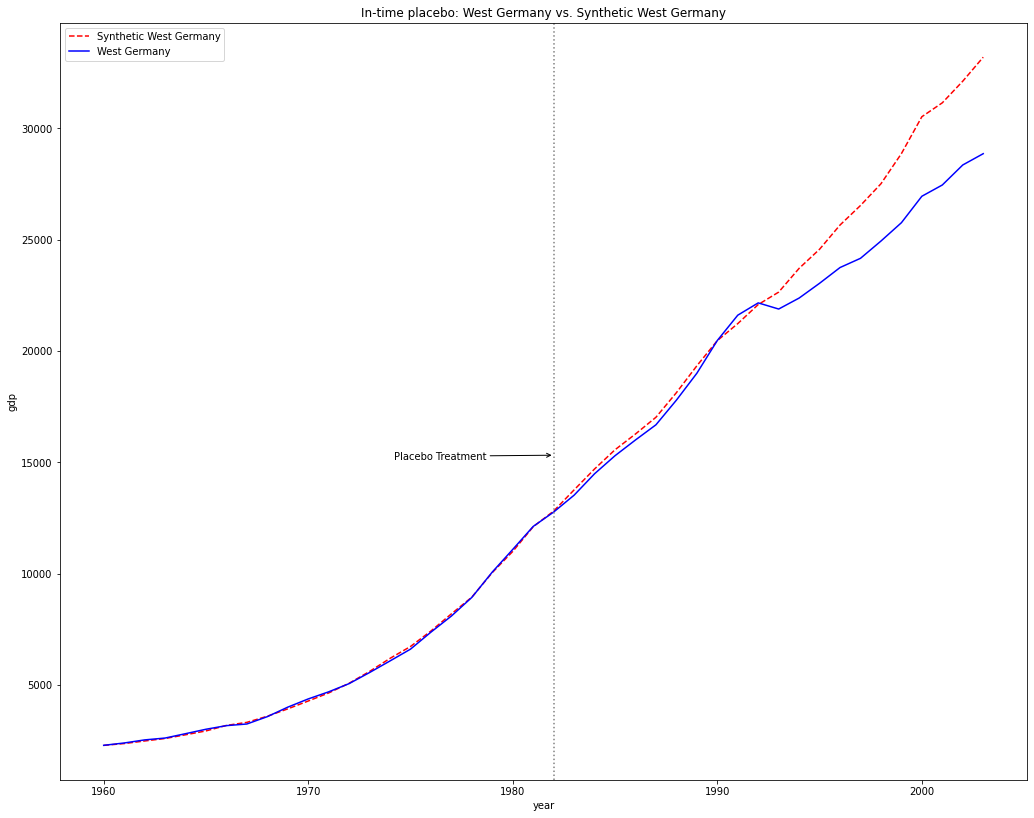

In [17]:
#In-time placebo
#Placebo treatment period is 1982, 8 years earlier
sc_pen.in_time_placebo(1982, n_optim=10)

#Visualize
sc_pen.plot(['in-time placebo'], 
            treated_label="West Germany",
            synth_label="Synthetic West Germany")

/Users/oscarengelbrektson/Documents/Minerva/Capstone_Project/SyntheticControlMethods/SyntheticControlMethods/plot.py:234: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


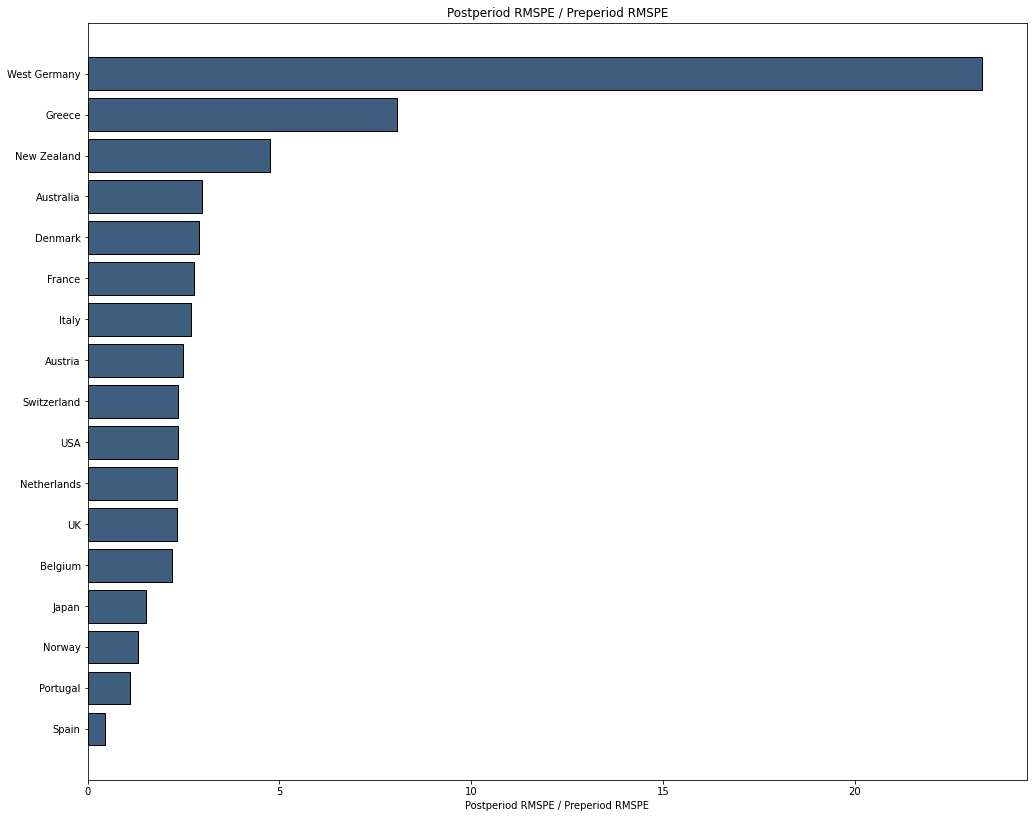

In [18]:
#Compute in-space placebos
sc_pen.in_space_placebo(15)

#Visualize
sc_pen.plot(['rmspe ratio'])

 # Using Differenced Synthetic Control, DiffSynth

### What is a Differenced Synthetic Control?


A key insight that Consequently, DiffSynth has a larger solution space.

In general, I recommend using DiffSynth if the Synth does not do a good job–there is a chance DiffSynth might because of the extra flexibility. For example, if the outcome of the treated unit is more extreme than those of any or most of the control units, then ordinary synthetic control is bound to fail, as the convexity constraint on the weights (can never sum to more than 1), means the best synthetic control will assign all weight to the most extreme control unit. In this case, DiffSynth will not have a problem as it tries only to construct a synthetic control that changes the same way as the treated unit, not one that changes the same way and has the same level as the treated unit. Further, __Use DiffSynth with pen="auto"__ to mitigate bias that could follow from increased flexibility.

Note: Differenced Synthetitic Controls do not exist in the literature - I propose them in my forthcoming thesis advised by Professor Alexis Diamond, one of the coauthors on the works introducing the original Synthetic Control (Abadie, Diamond & Hainmueller, 2010; Abadie, Diamond & Hainmueller, 2015).


### How to use Differenced Synthetic Controls
Differerenced synthetic controls are called using DiffSynth() instead of Synth(). I takes one additional, optional argument, apart from that you use it exactly the same way as Synth and interpret the results the same way. There is one exception, in terms, of interpretation: the comparison table, it will show the average _change_ instead of the average values of the covariates (example below).

Differenced Synthetic Control is fit using the DiffSynth() method, which takes the following inputs:

* **not_diff_cols**: Type: list. Default: []. List of column names to omit from pre-processing, e.g. compute the first difference for. Typically, columns should be included if the proportion of missing values is high. This is because the first difference is only defined for two consecutive values.


In [19]:
dsc = DiffSynth(data, "gdp", "country", "year", 1990, "West Germany", 
                  not_diff_cols=["schooling", "invest60", "invest70", "invest80"],
                  n_optim=100)

Because "schooling", "invest60", "invest70" and "invest80" all have 97% missing data, i.e. one observation per variable per unit, taking the first difference of them is not fruitful. If we do it before imputing missing values, the change is not defined as there is nothing to compare it to. If we do it after imputing values, regardless of which imputation strategy we use, for any unit, we would assign the same value to each time period. In turn, this would mean that the change between any two time periods would be zero. Either way, the informational value of the covariates would be lost.

This is a general weakness of the first difference approach–in these cases it is best to not compute the first difference, by including the columns in the not_diff_cols argument. That said, there are still benefits to be reaped by differencing the outcome and the remaining covariates.

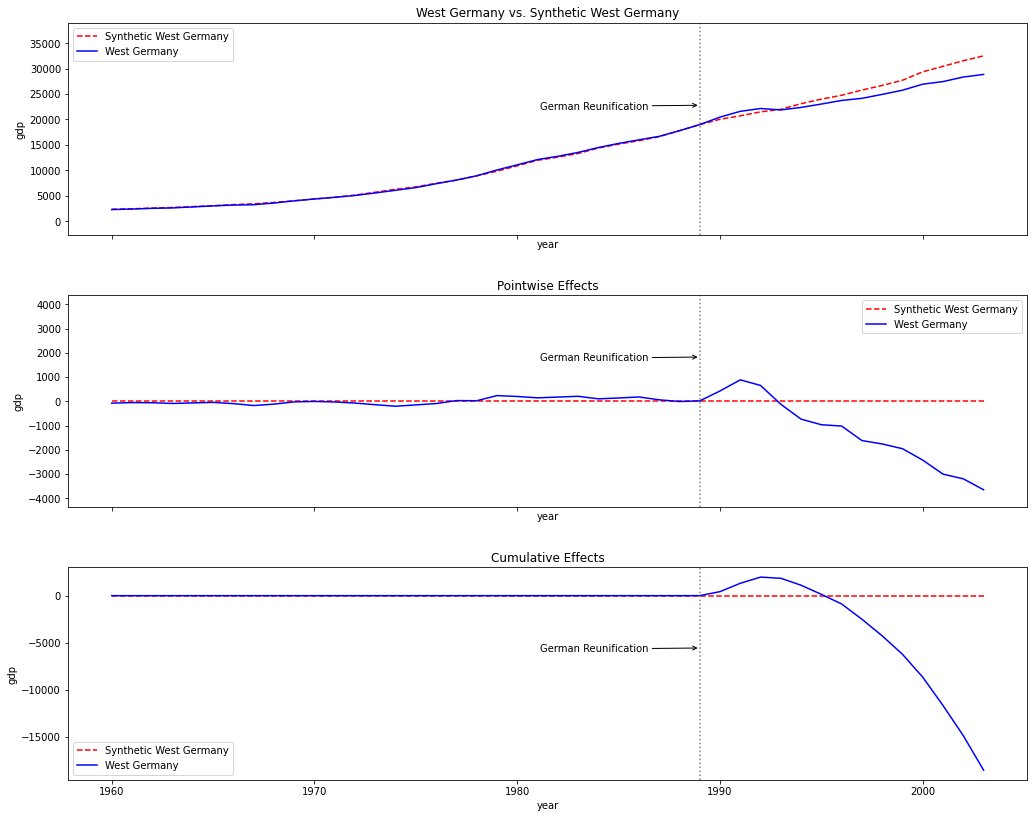

In [20]:
#Visualize
dsc.plot(["original", "pointwise", "cumulative"], treated_label="West Germany", 
            synth_label="Synthetic West Germany", treatment_label="German Reunification")

In [21]:
dsc.original_data.weight_df

,Weight
USA,0.396783
Belgium,0.524202
Portugal,0.027761
New Zealand,0.051254


In [22]:
#The differenced synthetic control outcome has been shifted upwards by 134 units
dsc.original_data.synth_constant

134.4429712465385

In [23]:
#RMSPE for Synthetic West Germany vs. West Germany
dsc.original_data.rmspe_df

,unit,pre_rmspe,post_rmspe,post/pre
0,West Germany,120.346826,1927.299384,16.014543


It should be noted that the pre-treatment fit on the outcome, whilst still excellent, is somewhat worse than that or ordinary Synth for this application. Notice, however, that in the outcome plot DiffSynth matches the outcome perfectly over the last time-periods before the German Reunification–Synth, both penalized and ordinary, overestimated West Germany's GDP. This results in a somewhat lower treatment effect estimate as indicated by post_rmspe––which may actually be more appropriate/accurate than Synth and PenSynth––and therefore also a lower post/pre ratio.

In [24]:
dsc.original_data.comparison_df

,West Germany,Synthetic West Germany,WMAPE,Importance
gdp,576.21,572.96,1115.58,0.12
infrate,3.39,5.52,2.13,0.15
trade,46.11,67.65,45.80,0.16
schooling,55.27,38.28,17.73,0.15
invest60,0.34,0.26,0.08,0.08
invest70,0.33,0.27,0.06,0.10
invest80,27.02,22.39,4.63,0.07
industry,40.10,36.27,4.70,0.16


The only difference in interpreting DiffSynth results from Synth are in the first two columns of this table. Notice the West Germany values are different for every covariate (except the ones include in not_diff_cols). This is because they show the average change in the covariate value from the previous year (previous time period, in general/any application), instead of the average value. The differenced synthetic control tries to construct a synthetic control that changes the same way as the treated unit, so that the outcomes are parallel in the pre-treatment period. Similar to Difference-in-Differences methods, a constant offset can then be included to shift the synthetic control pre-treatment outcome up to the same level as the treated unit.

__WMAPE__: Notice that the third column is still displaying unitwise average differences in the values of the covariates, _not_ the change.

## Validity testing of DSC
The validity tests for DSC work and can be interpreted the same way as they are for SC.

### In-time placebo

/Users/oscarengelbrektson/Documents/Minerva/Capstone_Project/SyntheticControlMethods/SyntheticControlMethods/plot.py:256: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


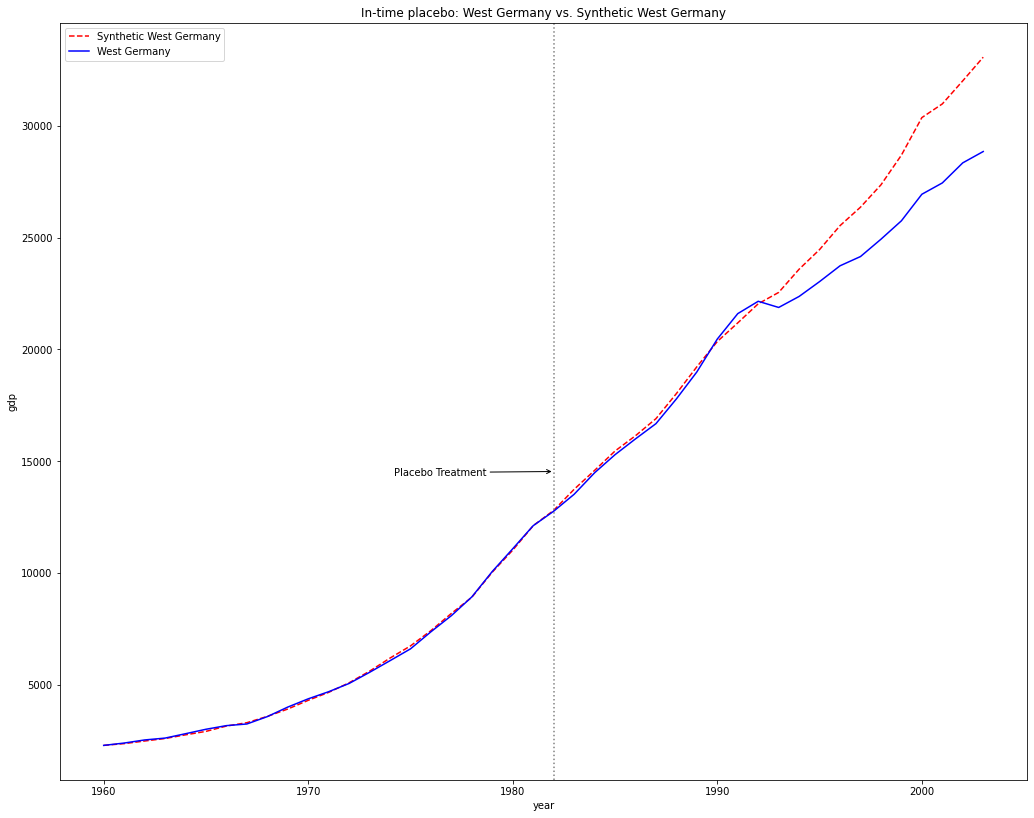

In [25]:
#In-time placebo
#Placebo treatment period is 1982, 8 years earlier
dsc.in_time_placebo(1982)

#Visualize
dsc.plot(['in-time placebo'], 
            treated_label="West Germany",
            synth_label="Synthetic West Germany")

Note the striking similarity of the in-time placebo synthetic control unit and the real synthetic control unit generated by DiffSynth.

### In-space placebo

/Users/oscarengelbrektson/Documents/Minerva/Capstone_Project/SyntheticControlMethods/SyntheticControlMethods/plot.py:234: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


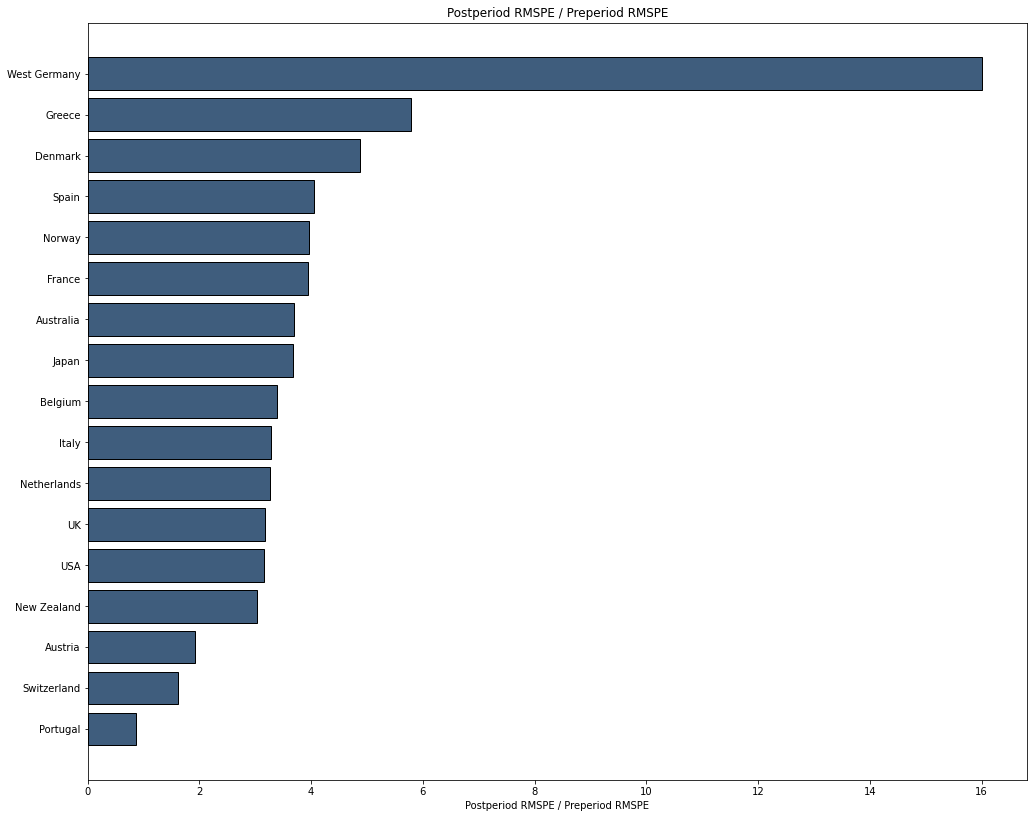

In [26]:
#Compute in-space placebos
dsc.in_space_placebo(15)

#Visualize
dsc.plot(['rmspe ratio'])

The RMSPE ratio of West Germany is lower using the DSC as compared to SC (16 vs 23). Simultaneously, the distribution of placebo units is grouped comparably closely towards 0 using DSC. The highest placebo RMSPE for DSC is 6 (Greece), whereas the highest for SC is 10 (Norway). On the whole, this means that the synthetic control estimate of West Germany is similar in terms of in-space placebo significance using DSC, as compared to SC.

### Variable descriptions and data sources:
* **GDP per Capita (PPP, 2002 USD):** Source: OECD National Accounts (retrieved via the OECD Health Database). Data for West Germany was obtained from Statistisches Bundesamt 2005 (Arbeitskreis “Volkswirtschaftliche Gesamtrechnungen der Lander”) and converted using PPP ¨monetary conversion factors (retrieved from the OECD Health Database).  
* **Investment Rate:** Ratio of real domestic investment (private plus public) to real GDP. The data are reported in five-year averages. Source: Barro, Robert Joseph, and Jong-wha Lee. 1994. “Data Set for a Panel of 138 Countries.” Available at http://www.nber.org/pub/barro.lee/.  
* **Schooling**: Percentage of secondary school attained in the total population aged 25 and older. The data are reported in five-year increments. Source: Barro, Robert Joseph, and Jong-wha Lee. 2000. “International Data on Educational Attainment: Updates and Implications.” CID Working Paper No. 42, April 2000 – Human Capital Updated Files.  
* **Industry**: industry share of value added. Source: World Bank WDI Database 2005 and Statistisches Bundesamt 2005.  
* **Inflation**: annual percentage change in consumer prices (base year 1995). Source: World Development Indicators Database 2005 and Statistisches Bundesamt 2005.  
* **Trade Openness**: Export plus imports as percentage of GDP. Source: World Bank: World Development Indicators CD-ROM 2000.